# Rat weight gain data in lmer, lmm, Stan and Mamba

The `rats` data are described in the `RatWeightData` notebook where they are converted from a matrix to a saved R data frame.  We could do the initial data manipulation in [R](http://R-project.org) through the [RCall](https://github.com/JuliaStats/RCall.jl) package for [Julia](https://julialang.org) but we chose to use packages from the "Hadleyverse" that cannot easily be installed on (https://juliabox.org)

In [1]:
using RCall
reval("""rats <- readRDS("rats.rds")""")
@rget rats

,id,day,y
1,1,8,151
2,2,8,145
3,3,8,147
4,4,8,155
5,5,8,135
6,6,8,159
7,7,8,141
8,8,8,159
9,9,8,177
10,10,8,134


## Plot the data

At this point we do something radical and plot the data.  I have never seen a data plot in any of the MCMC exampes that use these data.  The panels are ordered (bottom to top, left to right) according to increasing average weight of the rat.  The aspect ratio is chosen so that a typical slope of the within-rat least squares line is approximately 45 degrees on the plotting surface.

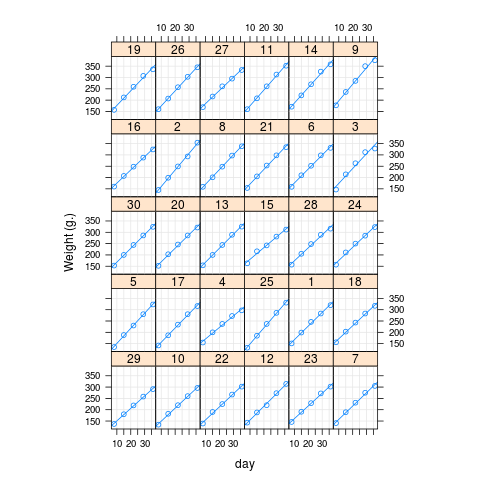

RCall.RObject{RCall.VecSxp}


In [2]:
"""
library(lattice)
print(xyplot(y ~ day | reorder(id, y), 
rats, type = c('p','g','r'), aspect = 'xy', 
ylab = "Weight (g.)"))
""" |> reval

There is an overall linear trend in the weight with respect to time but there is also noticeable downward curvature for many of the rats.  Nevertheless we will start with a model with linear model with vector-valued random effects for slope and intercept by rat.

## Fitting the vector-valued random effects in lme4

The simplest way to write the model is `weight ~ 1 + day + (1 + day|id)` which allows for correlated random effects for slope and intercept for each rat.  (There's a bug in the `RCall` package that causes the plot to be printed twice.)

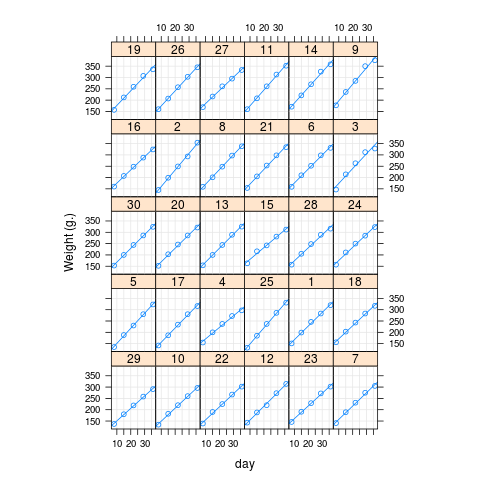

RCall.RObject{RCall.VecSxp}
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: y ~ 1 + day + (1 + day | id)
   Data: rats

     AIC      BIC   logLik deviance df.resid 
  1108.1   1126.1   -548.0   1096.1      144 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6317 -0.5422  0.1154  0.4948  2.6188 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 id       (Intercept) 110.1392 10.4947       
          day           0.2495  0.4995  -0.15
 Residual              36.1756  6.0146       
Number of obs: 150, groups:  id, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept) 106.5676     2.2591   47.17
day           6.1857     0.1038   59.58

Correlation of Fixed Effects:
    (Intr)
day -0.343


In [3]:
"""
suppressPackageStartupMessages(library(lme4))
m1 <- lmer(y ~ 1 + day + (1 + day|id), rats, REML = FALSE)
summary(m1)
""" |> reval

Because `day` is days past birth, the estimate of a typical birth weight is 106.6 g. and the typical weight gain per day after birth is 6.2 g./day.  As is common in linear regression models where `x = 0` is to the left of the observed data, there is a negative correlation, -0.343, between these estimates.  The standard deviation of the random effects for the intercept (i.e. the birth weight) is 10.5 g. and the standard deviation of the random effects for the slope is 0.50 g./day.  There is a slight negative within-rat correlation, -0.15, of these random effects.  We can check the conditional means of these random effects

In [4]:
rcall(:ranef, :m1)

RCall.RObject{RCall.VecSxp}
$id
    (Intercept)         day
1   -0.05553214 -0.12578651
2  -11.28871381  0.78307023
3    2.56173870  0.33371487
4    6.95772594 -0.80488489
5  -15.66765773  0.23713605
6    5.86444226  0.04898243
7   -7.44611157 -0.29292676
8    0.49139122  0.24410473
9   17.10933172  1.07538535
10 -12.66716696 -0.48326773
11   1.53330811  0.65324070
12 -10.44571308 -0.17582192
13   0.19475081 -0.02076168
14  11.51006572  0.64210468
15  13.77174164 -0.65506265
16   6.80249948 -0.20317462
17  -9.93634401 -0.01121433
18   4.30992548 -0.30851412
19   5.00795524  0.27921279
20   1.52862500 -0.12086316
21   0.84085073  0.23631872
22  -8.07783593 -0.42464430
23  -3.50288046 -0.49138374
24   7.23352917 -0.23288734
25 -19.40139098  0.55158120
26   2.62570253  0.40267231
27  14.44659266 -0.14725654
28   6.31630913 -0.28786142
29 -10.62557058 -0.64438331
30   0.00843169 -0.05682907



or, a better choice, plot these conditional modes.

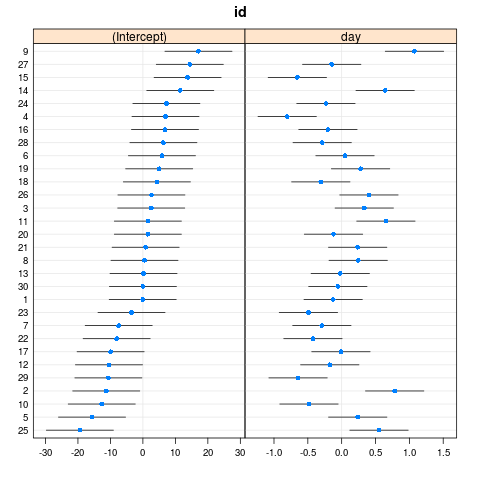

In [5]:
"""
re1 <- ranef(m1, condVar = TRUE)
print(dotplot(re1, scales = list(x = list(relation = 'free'))))[[1]]
""" |> reval;

We can check for non-negligible correlation of the random effects by fitting a model with uncorrelated random effects and comparing the fits.

In [6]:
"""
m2 <- lmer(y ~ 1 + day + (1|id) + (0 + day|id), rats, REML = FALSE)
options(show.signif.stars = FALSE)
anova(m2, m1)
""" |> reval

RCall.RObject{RCall.VecSxp}
$id

Data: rats
Models:
m2: y ~ 1 + day + (1 | id) + (0 + day | id)
m1: y ~ 1 + day + (1 + day | id)
   Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
m2  5 1106.4 1121.5 -548.21   1096.4                         
m1  6 1108.1 1126.1 -548.03   1096.1 0.3645      1      0.546


In [8]:
rcall(:summary, :m2)

RCall.RObject{RCall.VecSxp}
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: y ~ 1 + day + (1 | id) + (0 + day | id)
   Data: rats

     AIC      BIC   logLik deviance df.resid 
  1106.4   1121.5   -548.2   1096.4      145 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5962 -0.5331  0.1162  0.5036  2.5868 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 101.6460 10.0820 
 id.1     day           0.2319  0.4815 
 Residual              36.8273  6.0686 
Number of obs: 150, groups:  id, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept) 106.5676     2.2014   48.41
day           6.1857     0.1012   61.14

Correlation of Fixed Effects:
    (Intr)
day -0.247


## Fitting the same models with lmm in Julia

First we copy the `rats` data frame from R to Julia then fit the models

In [9]:
using DataFrames, Distributions, Mamba, MixedModels
m1 = fit!(lmm(y ~ 1 + day + (1 + day|id), rats))

Linear mixed model fit by maximum likelihood
 logLik: -548.028661, deviance: 1096.057323, AIC: 1108.057323, BIC: 1126.121134

Variance components:
            Variance     Std.Dev.    Corr.
 id       110.13955819 10.49473955
            0.24951838  0.49951815 -0.15
 Residual  36.17558280  6.01461410
 Number of obs: 150; levels of grouping factors: 30

  Fixed-effects parameters:
             Estimate Std.Error z value
(Intercept)   106.568   2.25911 47.1724
day           6.18571  0.103818 59.5822


The two mixed-models packages agree on the fit.  The amount of time required for the lmm fit is

In [10]:
@time fit!(lmm(y ~ 1 + day + (1 + day|id), rats));

  0.013580 seconds (61.33 k allocations: 2.413 MB)


In [11]:
m2 = fit!(lmm(y ~ 1 + day + (1|id) + (0 + day|id), rats))

Linear mixed model fit by maximum likelihood
 logLik: -548.210888, deviance: 1096.421776, AIC: 1106.421776, BIC: 1121.474952

Variance components:
            Variance     Std.Dev.  
 id       101.64629290 10.08197862
 id         0.23188824  0.48154776
 Residual  36.82725545  6.06854640
 Number of obs: 150; levels of grouping factors: 30, 30

  Fixed-effects parameters:
             Estimate Std.Error z value
(Intercept)   106.568   2.20142 48.4085
day           6.18571  0.101168 61.1433


In [12]:
MixedModels.lrt(m2, m1)  # print format is still a bit primitive

,Df,Deviance,Chisq,pval
1,5,1096.4217755749055,NaN,NaN
2,6,1096.057322702283,0.36445287262245074,0.5460435643032959


## A Stan analysis of the independent r.e. model

The independent random effects model, `m2`, has been a standard example for MCMC methods since the original [BUGS](http://www.openbugs.org) system.  The Stan examples respository, https://github.com/stan-dev/example-models, contains links to this example in OpenBUGS and in Stan, under `bugs-examples/vol1/rats/`.

The [Stan package](https://github.com/goedman/Stan.jl) for Julia is similar to [rstan](https:://mc-stan.org/interfaces/rstan/) in that the interactive language is used to marshall the data which is then passed to a stan program. The initial version of the model uses the data in the form of a matrix of response values, `y`, and a separate vector of times called `x`.  Because Stan is a statically-typed language (it is transformed to C++ code), the sizes of all arrays must be given explicitly.  The data should be available as a `Dict{ASCIIString,Any}` type.

In [13]:
const ratsdict = Dict(
"N" => 30, 
"T" => 5, 
"x" => [8.,15,22,29,36],
"xbar" => 22.,
"y" => reshape(convert(Vector{Float64}, rats[:y]), (30, 5)))

Dict{ASCIIString,Any} with 5 entries:
  "T"    => 5
  "N"    => 30
  "x"    => [8.0,15.0,22.0,29.0,36.0]
  "xbar" => 22.0
  "y"    => 30x5 Array{Float64,2}:…

We create the model from a long text string

In [14]:
using Mamba, Stan
ratstan = Stanmodel(name = "rats", model = """
# http://www.mrc-bsu.cam.ac.uk/bugs/winbugs/Vol1.pdf
# Page 3: Rats
data {
  int<lower=0> N;
  int<lower=0> T;
  real x[T];
  real y[N,T];
  real xbar;
}
parameters {
  real alpha[N];
  real beta[N];

  real mu_alpha;
  real mu_beta;          // beta.c in original bugs model

  real<lower=0> sigmasq_y;
  real<lower=0> sigmasq_alpha;
  real<lower=0> sigmasq_beta;
}
transformed parameters {
  real<lower=0> sigma_y;       // sigma in original bugs model
  real<lower=0> sigma_alpha;
  real<lower=0> sigma_beta;

  sigma_y <- sqrt(sigmasq_y);
  sigma_alpha <- sqrt(sigmasq_alpha);
  sigma_beta <- sqrt(sigmasq_beta);
}
model {
  mu_alpha ~ normal(0, 100);
  mu_beta ~ normal(0, 100);
  sigmasq_y ~ inv_gamma(0.001, 0.001);
  sigmasq_alpha ~ inv_gamma(0.001, 0.001);
  sigmasq_beta ~ inv_gamma(0.001, 0.001);
  alpha ~ normal(mu_alpha, sigma_alpha); // vectorized
  beta ~ normal(mu_beta, sigma_beta);  // vectorized
  for (n in 1:N)
    for (t in 1:T) 
      y[n,t] ~ normal(alpha[n] + beta[n] * (x[t] - xbar), sigma_y);

}
generated quantities {
  real alpha0;
  alpha0 <- mu_alpha - xbar * mu_beta;
}
""", 
data = [ratsdict], 
monitors = ["mu_alpha", "mu_beta", "sigma_y", "sigma_alpha", "sigma_beta"])

  name =                    "rats"
  nchains =                 4
  update =                   1000
  adapt =                    1000
  thin =                     1
  monitors =                ASCIIString["mu_alpha","mu_beta","sigma_y","sigma_alpha","sigma_beta"]
  model_file =              "rats.stan"
  data_file =                ""
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  Stan.diag_e
      stepsize =                1.0


      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


In [15]:
sim1 = stan(ratstan);

LoadError: LoadError: UndefVarError: CMDSTAN_HOME not defined
while loading In[15], in expression starting on line 1

I'm not exactly sure what to do here in that, as far as I can tell, `CMDSTAN_HOME` should be defined.

## A Mamba MCMC analysis of the independent random effects model

[Brian Smith](http://www.public-health.uiowa.edu/people/brian-smith/), the principal author of the [Mamba package](https://github.com/brian-j=smith/Mamba.jl) provides a BUGS-like approach to this model in the [Mamba documentation](http://mambajl.readthedocs.org/en/latest/examples/rats.html) which we will adapt here.  First we need to convert the data in the `rats` DataFrame, which are stored as `DataArray` types, to vectors.  These are stored in a dictionary with keys that are symbols.  This is similar to an R list except that there is no inherent ordering of the elements.  You can retrieve values by name (symbol) but not by index number.

In [ ]:
ratsD = Dict(  # data for Mamba are in the form of a Dict{Symbol,Any}
:y => convert(Vector{Float64}, rats[:y]), 
:id => convert(Vector{Int}, rats[:id]),
:Xt => hcat(ones(length(rats[:day])), rats[:day])')

In [ ]:
const mu = similar(ratsD[:y]);
function μfun(β, b, Xt, id)
    Ac_mul_B!(mu, Xt, β)  # fixed-effects contribution 
    for j in eachindex(mu)
        mu[j] += dot(slice(Xt, :, j), slice(b, :, id[j]))
    end
    mu
end

A simple test of the function to determine if it reproduces the fitted values from `m2`

In [ ]:
const bb = ranef(m2);
μfun(coef(m2), vcat(bb[1], bb[2]), ratsD[:Xt], ratsD[:id])

In [ ]:
model = Model(
  y  = Stochastic(1, (μ, σ) -> MvNormal(μ, σ), false),
  β  = Stochastic(1, () -> MvNormal(2, 1000.)),
  b  = Stochastic(2, (σ²₁, σ²₂) -> MvNormal(PDiagMat([σ²₁, σ²₂]))),
  μ  = Logical(1, (β, b, Xt, id) -> μfun(β, b, Xt, id), false),
  σ² = Stochastic(() -> InverseGamma(0.001, 0.001), false),
  σ  = Logical((σ²) -> √σ²),
  σ²₁ = Stochastic(() -> InverseGamma(0.001, 0.001), false),
  λ₁ = Logical((σ²₁, σ) -> √σ²₁ / σ),
  σ²₂ = Stochastic(() -> InverseGamma(0.001, 0.001), false),
  λ₂ = Logical((σ²₂, σ) -> √σ²₂ / σ)
)

## Defining a Gibbs sampler for the coefficients

Initially we will ignore the prior on $\beta$ and simply use the mechanism created for the model `m2` to provide a Gibbs sampler for the fixed-effects and the random effects.

In [ ]:
fieldnames(m2)

The important members of this structure for updates are `Λ`, `A` and `R`.  `A` and `R` are partitioned matrices.

In [ ]:
A = m2.A;
size(A)

In [ ]:
R = m2.R;
size(R)

In [ ]:
for j in 1:3, i in 1:j
    @show i, j, typeof(A[i,j]), typeof(R[i,j])
end

In [ ]:
typeof(m2.Λ)

In [ ]:
size(m2.Λ)

In [ ]:
m2[:θ]